In [3]:
import os 
import SimpleITK as sitk
import numpy as np
import random
import cv2
from skimage.measure import regionprops_table
import pandas as pd




In [1]:

folder_path = '' #path to top folder containing patient directories. 
label_meta_data_path = '' #csv file with patient IDs and corresponding diagnostic labels.
output_path= '' #folder where montages will be saved.

given_size = (350,350)
percentage_removal = 10

subject_meta = pd.read_csv(label_meta_data_path)
subject_meta.set_index('name',inplace=True)

In [3]:
def list_subfolders(directory):
    subfolders = [f.name for f in os.scandir(directory) if f.is_dir()]
    return subfolders

# here and in subsequent code, variable "core_name" refers to the Patient ID.

def get_refined_images(core_name, sigma):

    #MCI
    file_path_mask = os.path.join(folder_path,core_name,'mask', f'{core_name}.nhdr') # mask
    file_path_raw = os.path.join(output_path,core_name,'MCI', f'{core_name}_MCI{sigma}.nhdr') # raw
    image_mask = sitk.ReadImage(file_path_mask)
    data_mask = sitk.GetArrayFromImage(image_mask)
    image_raw = sitk.ReadImage(file_path_raw)
    data_raw = sitk.GetArrayFromImage(image_raw)
    non_zero_slices = [i for i in range(data_mask.shape[0]) if np.any(data_mask[i])]
    start = non_zero_slices[0] #0
    end = non_zero_slices[-1] #-1
    image = data_mask*data_raw
    image = np.nan_to_num(image)
    image_non_zero = image[start:end,:,:]
    num_slices = image_non_zero.shape[0]
    slices_to_remove = int(np.ceil(num_slices)*(percentage_removal/100))
    image_mci_refined = image_non_zero[slices_to_remove:-slices_to_remove,:,:]
    
    #CT
    file_path_raw = os.path.join(folder_path,core_name,'CT', 'CT_image.nhdr') # raw
    image_ct_raw = sitk.ReadImage(file_path_raw)
    data_ct_raw = sitk.GetArrayFromImage(image_ct_raw)
    image_ct = data_mask*data_ct_raw
    image_ct = np.nan_to_num(image_ct)
    image_ct_non_zero = image_ct[start:end,:,:]
    image_ct_refined = image_ct_non_zero[slices_to_remove:-slices_to_remove,:,:]

    mask_non_zero = data_mask[start:end,:,:]
    mask_refined = mask_non_zero[slices_to_remove:-slices_to_remove,:,:]

    return image_ct_refined, image_mci_refined, mask_refined


def create_random_montage(image_refined, image_refined_mci,mask_refined,given_size):
    
    max_p_size = 390
    max_p4_size=max_p_size-8

    num_slices_rem = image_refined.shape[0]
    sl_1 = random.randint(0, int(num_slices_rem/4)-1)
    sl_2 = random.randint(int(num_slices_rem/4), int(num_slices_rem/2)-1)
    sl_3 = random.randint(int(num_slices_rem/2), int(3*num_slices_rem/4)-1)
    sl_4 = random.randint(int(3*num_slices_rem/4), num_slices_rem-1)

    mask_sl_1 = mask_refined[sl_1,:,:]
    mask_sl_2 = mask_refined[sl_2,:,:]
    mask_sl_3 = mask_refined[sl_3,:,:]
    mask_sl_4 = mask_refined[sl_4,:,:]

    props = regionprops_table(mask_sl_1)
    min_row1=props['bbox-0'][0]
    min_col1=props['bbox-1'][0]
    max_row1=props['bbox-2'][0]
    max_col1=props['bbox-3'][0]
    width1 = max_col1-min_col1
    height1 = max_row1-min_row1

    props = regionprops_table(mask_sl_2)
    min_row2=props['bbox-0'][0]
    min_col2=props['bbox-1'][0]
    max_row2=props['bbox-2'][0]
    max_col2=props['bbox-3'][0]
    width2 = max_col2-min_col2
    height2 = max_row2-min_row2

    props = regionprops_table(mask_sl_3)
    min_row3=props['bbox-0'][0]
    min_col3=props['bbox-1'][0]
    max_row3=props['bbox-2'][0]
    max_col3=props['bbox-3'][0]
    width3 = max_col3-min_col3
    height3 = max_row3-min_row3

    props = regionprops_table(mask_sl_4)
    min_row4=props['bbox-0'][0]
    min_col4=props['bbox-1'][0]
    max_row4=props['bbox-2'][0]
    max_col4=props['bbox-3'][0]
    width4 = max_col4-min_col4
    height4 = max_row4-min_row4

    #CT montage
    img_sl_1 = image_refined[sl_1,:,:]
    img_sl_2 = image_refined[sl_2,:,:]
    img_sl_3 = image_refined[sl_3,:,:]
    img_sl_4 = image_refined[sl_4,:,:]

    image_slice_crop = img_sl_1[min_row1:min_row1+height1,min_col1:min_col1+width1]
    dim1=np.max([height1,width1])
    im_resized =  cv2.resize(image_slice_crop, (0,0), fx=max_p4_size/dim1,fy=max_p4_size/dim1, interpolation = cv2.INTER_CUBIC)
    if(dim1 == width1):
        padding = 4
        paddingH = int((max_p_size-(height1*max_p4_size/dim1))/2)
    else:
        paddingH = 4
        padding = int((max_p_size-(width1*max_p4_size/dim1))/2) 
    image_slice_pad1 = np.zeros((max_p_size,max_p_size))
    h1 = im_resized.shape[0]
    w1 = im_resized.shape[1]
    image_slice_pad1[paddingH:h1+paddingH, padding:w1+padding] = im_resized

    image_slice_crop = img_sl_2[min_row2:min_row2+height2,min_col2:min_col2+width2]
    dim2=np.max([height2,width2])
    im_resized =  cv2.resize(image_slice_crop, (0,0), fx=max_p4_size/dim2,fy=max_p4_size/dim2, interpolation = cv2.INTER_CUBIC)
    if(dim2 == width2):
        padding = 4
        paddingH = int((max_p_size-(height2*max_p4_size/dim2))/2)
    else:
        paddingH = 4
        padding = int((max_p_size-(width2*max_p4_size/dim2))/2)        
    image_slice_pad2 = np.zeros((max_p_size,max_p_size))
    h2 = im_resized.shape[0]
    w2 = im_resized.shape[1]
    image_slice_pad2[paddingH:h2+paddingH, padding:w2+padding] = im_resized


    image_slice_crop = img_sl_3[min_row3:min_row3+height3,min_col3:min_col3+width3]
    dim3=np.max([height3,width3])
    im_resized =  cv2.resize(image_slice_crop, (0,0), fx=max_p4_size/dim3,fy=max_p4_size/dim3, interpolation = cv2.INTER_CUBIC)
    if(dim3 == width3):
        padding = 4
        paddingH = int((max_p_size-(height3*max_p4_size/dim3))/2)
    else:
        paddingH = 4
        padding = int((max_p_size-(width3*max_p4_size/dim3))/2)        
    image_slice_pad3 = np.zeros((max_p_size,max_p_size))
    h3 = im_resized.shape[0]
    w3 = im_resized.shape[1]
    image_slice_pad3[paddingH:h3+paddingH, padding:w3+padding] = im_resized

    image_slice_crop = img_sl_4[min_row4:min_row4+height4,min_col4:min_col4+width4]
    dim4=np.max([height4,width4])
    im_resized =  cv2.resize(image_slice_crop, (0,0), fx=max_p4_size/dim4,fy=max_p4_size/dim4, interpolation = cv2.INTER_CUBIC)
    if(dim4 == width4):
        padding = 4
        paddingH = int((max_p_size-(height4*max_p4_size/dim4))/2)
    else:
        paddingH = 4
        padding = int((max_p_size-(width4*max_p4_size/dim4))/2)        
    image_slice_pad4 = np.zeros((max_p_size,max_p_size))
    h4 = im_resized.shape[0]
    w4 = im_resized.shape[1]
    image_slice_pad4[paddingH:h4+paddingH, padding:w4+padding] = im_resized

    width = max_p_size
    height = max_p_size
    montage_size = (width*2, height*2)
    montage = np.zeros(montage_size)
    montage[0:width,0:height] = image_slice_pad1
    montage[width:,0:height] = image_slice_pad2
    montage[0:width,height:] = image_slice_pad3
    montage[width:,height:] = image_slice_pad4

    montage = cv2.resize(montage, given_size)

    #MCI montage

    img_sl_1 = image_refined_mci[sl_1,:,:]
    img_sl_2 = image_refined_mci[sl_2,:,:]
    img_sl_3 = image_refined_mci[sl_3,:,:]
    img_sl_4 = image_refined_mci[sl_4,:,:]

    image_slice_crop = img_sl_1[min_row1:min_row1+height1,min_col1:min_col1+width1]
    dim1=np.max([height1,width1])
    im_resized =  cv2.resize(image_slice_crop, (0,0), fx=max_p4_size/dim1,fy=max_p4_size/dim1, interpolation = cv2.INTER_CUBIC)
    if(dim1 == width1):
        padding = 4
        paddingH = int((max_p_size-(height1*max_p4_size/dim1))/2)
    else:
        paddingH = 4
        padding = int((max_p_size-(width1*max_p4_size/dim1))/2)        
    image_slice_pad1 = np.zeros((max_p_size,max_p_size))
    h1 = im_resized.shape[0]
    w1 = im_resized.shape[1]
    image_slice_pad1[paddingH:h1+paddingH, padding:w1+padding] = im_resized

    image_slice_crop = img_sl_2[min_row2:min_row2+height2,min_col2:min_col2+width2]
    dim2=np.max([height2,width2])
    im_resized =  cv2.resize(image_slice_crop, (0,0), fx=max_p4_size/dim2,fy=max_p4_size/dim2, interpolation = cv2.INTER_CUBIC)
    if(dim2 == width2):
        padding = 4
        paddingH = int((max_p_size-(height2*max_p4_size/dim2))/2)
    else:
        paddingH = 4
        padding = int((max_p_size-(width2*max_p4_size/dim2))/2)        
    image_slice_pad2 = np.zeros((max_p_size,max_p_size))
    h2 = im_resized.shape[0]
    w2 = im_resized.shape[1]
    image_slice_pad2[paddingH:h2+paddingH, padding:w2+padding] = im_resized


    image_slice_crop = img_sl_3[min_row3:min_row3+height3,min_col3:min_col3+width3]
    dim3=np.max([height3,width3])
    im_resized =  cv2.resize(image_slice_crop, (0,0), fx=max_p4_size/dim3,fy=max_p4_size/dim3, interpolation = cv2.INTER_CUBIC)
    if(dim3 == width3):
        padding = 4
        paddingH = int((max_p_size-(height3*max_p4_size/dim3))/2)
    else:
        paddingH = 4
        padding = int((max_p_size-(width3*max_p4_size/dim3))/2)        
    image_slice_pad3 = np.zeros((max_p_size,max_p_size))
    h3 = im_resized.shape[0]
    w3 = im_resized.shape[1]
    image_slice_pad3[paddingH:h3+paddingH, padding:w3+padding] = im_resized

    image_slice_crop = img_sl_4[min_row4:min_row4+height4,min_col4:min_col4+width4]
    dim4=np.max([height4,width4])
    im_resized =  cv2.resize(image_slice_crop, (0,0), fx=max_p4_size/dim4,fy=max_p4_size/dim4, interpolation = cv2.INTER_CUBIC)
    if(dim4 == width4):
        padding = 4
        paddingH = int((max_p_size-(height4*max_p4_size/dim4))/2)
    else:
        paddingH = 4
        padding = int((max_p_size-(width4*max_p4_size/dim4))/2)        
    image_slice_pad4 = np.zeros((max_p_size,max_p_size))
    h4 = im_resized.shape[0]
    w4 = im_resized.shape[1]
    image_slice_pad4[paddingH:h4+paddingH, padding:w4+padding] = im_resized

    width = max_p_size
    height = max_p_size
    montage_size = (width*2, height*2)
    montage_mci = np.zeros(montage_size)
    montage_mci[0:width,0:height] = image_slice_pad1
    montage_mci[width:,0:height] = image_slice_pad2
    montage_mci[0:width,height:] = image_slice_pad3
    montage_mci[width:,height:] = image_slice_pad4

    montage = cv2.resize(montage, given_size)
    montage_mci = cv2.resize(montage_mci, given_size)

    return montage.astype(np.float32), montage_mci.astype(np.float32),[sl_1, sl_2, sl_3, sl_4]



def generate_unique_montages(num_montages, image_refined, image_refined_mci, mask_refined, given_size):    
    unique_coordinates = set()
    generated_montages = []
    generated_montages_mci = []
    created_montages = 0
    while created_montages < num_montages:
        random_image, random_image_mci,coordinate = create_random_montage(image_refined, image_refined_mci, mask_refined, given_size)
        coordinate_tuple = tuple(coordinate)
        if coordinate_tuple not in unique_coordinates:
                generated_montages.append(random_image)
                generated_montages_mci.append(random_image_mci)
                unique_coordinates.add(coordinate_tuple)
                created_montages += 1                
    return generated_montages, generated_montages_mci,unique_coordinates



def produce_SOFIA_2x2_montages(folder_path, output_path, subject_meta, given_size, percentage_removal):


    all_core_names = list_subfolders(folder_path)
    for core_name in all_core_names:
        if(core_name in subject_meta.index):

            print(core_name)

            stack_output_path = os.path.join(output_path,core_name,'SOFIAmontages')

            if (not os.path.exists(stack_output_path)):
                os.mkdir(stack_output_path)

            refined_image_ct, refined_image_mci, mask_refined = get_refined_images(core_name,2)

            generated_montages, generated_montages_mci,coordinates = generate_unique_montages(500, refined_image_ct, refined_image_mci, mask_refined,given_size)
            np.save(os.path.join(stack_output_path, 'montage.npy'), generated_montages)
            np.save(os.path.join(stack_output_path, 'montage_mci_2.npy'), generated_montages_mci)
            np.save(os.path.join(stack_output_path, 'montage_slice_coordinates.npy'), coordinates)



In [ ]:


produce_SOFIA_2x2_montages(folder_path, output_path, subject_meta, given_size, percentage_removal)

   

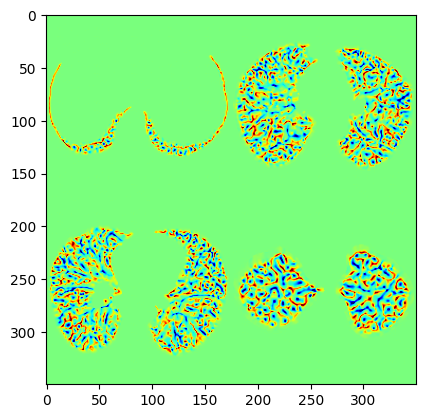

In [40]:
# The following is example code to visualize a montage

import matplotlib.pyplot as plt

test_subject_id = '122'
ct = np.load(os.path.join(output_path,test_subject_id,'SOFIAmontages','montage.npy'))
mci = np.load(os.path.join(output_path,test_subject_id,'SOFIAmontages','montage_mci_2.npy'))


plt.imshow(mci[250],cmap='jet',vmin=-1.5,vmax=1.5)

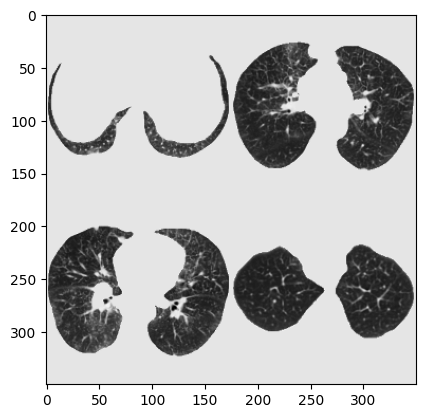

In [41]:
plt.imshow(ct[250],cmap='gray')